# Read and process data
This example covers:
1. Read data
2. Plot data
3. Normalise data
4. Save processed data

Reading is shown using published data for the article "Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study" (see reference at the end).

The published data includes nexus data (.nxs), text data (.dat) and athena (.prj), but for this example only the text and athena data are used.

## Resources
Pyhon modules and libraries used in this example

In [1]:
# code for importing custom helper libraries
import sys
# moved all custom helper libraries to a level bellow this directory.
sys.path.append('../lib/')

# Library with the functions that provide the larch functionalities
# equivalent to those provided by athena including normalisation, 
# merging, re-binning, LCF and visualisation (plotting)
import manage_athena as athenamgr 

# additional custom plot functions (replicate plots in published papers)
import custom_plots

# File handling
from pathlib import Path

# Handling json files
import json

# printing formated json data
import pprint

# to copy the mutable types like dictionaries, use copy/deepcopy 
import copy

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 

# 1. Read data
The process is divided in two steps. The first step entails reading the metadata which indicates the location of the data and some additional parameters such as column names, group names and file mappings. The second step uses this metadata to retrieve the experimental results from the files indicated in the metadata.
## Data mappings
Variables used for mapping published data to results in paper. In this case these data are for figure 4. The mappings are stored in a json file named figure_1_data.json

In [2]:
# name of the metadata with the mappings for figure 4 A
json_file = "figure_4_data.json"
mapping_data = {}

with open(json_file) as json_data:
    mapping_data = json.load(json_data)
    
pprint.pprint(mapping_data)


{'data_file': 'Xray_data.zip',
 'data_mapping': {'column_labels': 'energy time I0 It Iref  mu lnItIref',
                  'data_path': '../wf_data/pub_037/XAFS_prj/Sn K-edge/ascii',
                  'data_type': 'text',
                  'file_mappings': [{'group': 'PtSn',
                                     'pattern': '*_PtSn_OC_A*'},
                                    {'group': 'Air',
                                     'pattern': '*_PtSn_OCO_A*'},
                                    {'group': 'Ar', 'pattern': '*_PtSn_OCA_A*'},
                                    {'group': 'H2', 'pattern': '*_PtSn_OCH_A*'},
                                    {'group': 'PtSn H',
                                     'pattern': '*_PtSn_OC_H*'},
                                    {'group': 'Air H',
                                     'pattern': '*_PtSn_OCO_H*'},
                                    {'group': 'Ar H',
                                     'pattern': '*_PtSn_OCA_H*'},
                

##  Read data

The process below reads the data and merges the files indicated by the data mappings.
The data is merged as indicated in the original paper and its supplementary information.

In [3]:
merged_results={}
# read all samples, merge and then normalise
for a_sample in mapping_data['data_mapping']['file_mappings']:
    # pattern of the data file(s)
    file_pattern = a_sample['pattern']
    # name assigned to the readings for processing and display
    data_group =  a_sample['group']
    # directory where the files were downloaded
    data_path = Path(mapping_data['data_mapping']['data_path'])
    files_list = athenamgr.get_files_list(data_path, file_pattern)

    # read the files for each sample
    sample_list = []
    for i_count, a_file  in enumerate(files_list):
        file_name = a_file.name
        f_suffix = str(i_count).zfill(4) 
        # names assigned to the columns in the data files 
        column_labels = mapping_data['data_mapping']['column_labels']
        a_group = athenamgr.read_text(a_file, column_labels)
        sample_list.append(a_group)
    
    # merge readings for sample
    merged_xas = athenamgr.merge_readings(sample_list)

    # rename group (same as the file name)
    merged_xas.filename = data_group
    merged_results[data_group] = merged_xas

## 2. Plot data
The data recovered above is presented in the following plot.

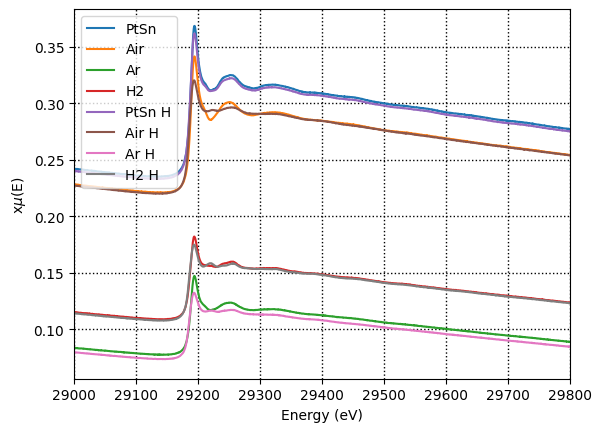

In [4]:
for a_sample in merged_results:
   plt = athenamgr.plot_mu(merged_results[a_sample])

plt.title("")
plt.xlim([29000, 29800])
plt.show()


# 3. normalise and plot
Normalisation is a common processing operation. The cell below performs the normalisation and plots the data to show the results.

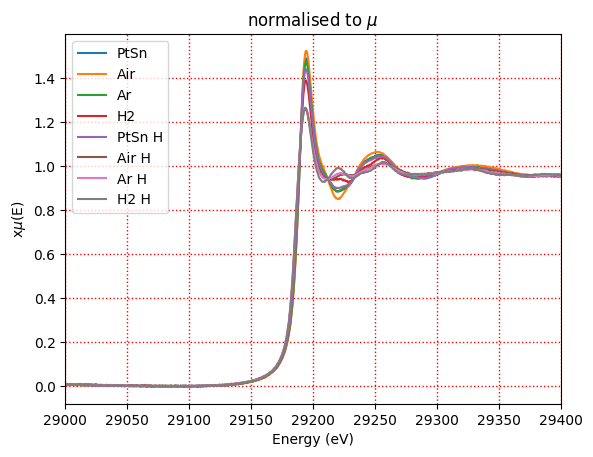

In [5]:
# Normalise all groups
for a_sample in merged_results:
    # calculate pre-edge, edge and anormalise each group
    # using defaults
    athenamgr.fit_pre_post_edge(merged_results[a_sample])
# Plot results
for a_sample in merged_results:
    plt = athenamgr.plot_normalised(merged_results[a_sample])
    
plt.xlim([29000, 29400])
plt.show()

# 4 Save data
The saving process is also divided in two steps, first the data is saved into an athena project, and then the corresponding  metadata is saved in a json file.

## Save Athena project
Store processed data in an Athena project file

In [6]:
# define the location of the output files
out_prefix = "PtSn_KEdge"
out_location = "../outputs"
# create a new output dir if it does not exist
out_dir = athenamgr.set_out_dir(out_prefix,out_location)
out_file = out_prefix+"_processed.prj"
# save the data to that output dir
athenamgr.save_groups(merged_results.values(), Path(out_dir, out_file))

## Save mappings
Store the metadata required to support further processing.

In [7]:
# save a json file with the results
# using the structure of the initial data mappings
out_mappings = copy.deepcopy(mapping_data)
file_mappings = []
for a_sample in merged_results:
    file_mappings.append ({'group':a_sample, 
                           'group_name':a_sample.replace(" ","_"),
                           'file_name': out_file.replace("\\","/")})

out_mappings['data_mapping']['data_path'] = str(out_dir).replace("\\","/")
out_mappings['data_mapping']['data_type'] = "athena"
out_mappings['data_mapping'].pop('column_labels')
out_mappings['data_mapping']['file_mappings'] = file_mappings

json_data = json.dumps(out_mappings, indent=4)
out_file_name = Path(out_dir, out_prefix+'_processed.json')
with open(out_file_name, 'w', encoding='utf-8') as f:
    f.write(json_data)
print("Mapping data saved to:", str(out_file_name))

Mapping data saved to: ..\outputs\PtSn_KEdge\PtSn_KEdge_processed.json


## References

The data used in this example is part of the supporting data for:

Huang, Haoliang, Nassr, Abu Bakr Ahmed Amine, Celorrio, Verónica, Taylor, S. F. Rebecca, Puthiyapura, Vinod Kumar, Hardacre, Christopher, Brett, Dan J. L., Russell, Andrea E. (2018) Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study. Faraday Discussions. V. 208. pp. 555-573. DOI:[10.1039/c7fd00221a](http://doi.org/10.1039/c7fd00221a).

The data used for reproducing the results was published in the Southampton Instituional Repository DOI: [10.5258/SOTON/D0408](https://eprints.soton.ac.uk/421798/), with the name Xray_data.zip - Dataset.